## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 

## Arguments & Initializations

In [5]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [6]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [7]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [8]:
DATASET = "law_sex"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [9]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 3 

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

egr_metrics = defaultdict(list) 
egr_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [10]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [11]:
dataset_orig.features.shape

(20798, 19)

In [12]:
privileged_groups

[{'gender': 1}]

In [13]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[4. 2. 7. ... 3. 5. 5.]
 [7. 6. 7. ... 3. 4. 4.]
 [6. 4. 7. ... 3. 4. 4.]
 ...
 [6. 7. 7. ... 3. 5. 5.]
 [2. 4. 7. ... 3. 6. 8.]
 [4. 7. 5. ... 5. 6. 8.]]


In [14]:
# NOT SUITABLE
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [15]:
dataset_orig_train

               instance weights features                                  \
                                                                           
                                 decile3 decile1 race cluster  lsat ugpa   
instance names                                                             
11301                       1.0      4.0     2.0  7.0     3.0  35.0  2.9   
14883                       1.0      7.0     6.0  7.0     3.0  32.0  2.7   
8316                        1.0      6.0     4.0  7.0     3.0  35.5  2.3   
6469                        1.0      2.0     7.0  4.0     6.0  25.0  2.0   
20767                       1.0     10.0    10.0  7.0     1.0  41.0  3.5   
...                         ...      ...     ...  ...     ...   ...  ...   
13864                       1.0      8.0     8.0  7.0     2.0  41.0  3.3   
118                         1.0      4.0     3.0  7.0     2.0  31.0  3.7   
5220                        1.0      6.0     7.0  7.0     3.0  30.0  3.4   
6744        

In [16]:
dataset_orig_train?

## Run Mitigating Algorithms

In [18]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

#### Train dataset's features are as below:
[[ 4.  4.  7. ...  3.  6.  6.]
 [10. 10.  7. ...  3.  6.  8.]
 [ 6.  8.  3. ...  1.  2.  2.]
 ...
 [10.  9.  7. ...  3.  4.  4.]
 [ 3.  2.  3. ...  5.  6.  6.]
 [ 3.  2.  7. ...  2.  5.  5.]]
no bias type specified
#### Training Dataset shape
(10399, 19)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'gender', 'race1', 'race2', 'other', 'asian', 'black', 'hisp', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  5831.0 4568.0
base_pos unpriv:  0.940893169877408
base_pos priv:  0.9542102555307838
number of favorable labels:  9862
Difference in mean outcomes between unprivileged and privileged groups = -0.013317

Number of training samples (ntrain): 5564
Number of test samples (ntest): 5586
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.6466271649250525
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 537, Test = 503
  AUC: 0.77
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.41
  Positive predictive value: 0.77
  Optimal thershold: -1.7117167615545184
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9862, Test = 9896
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.06899287148695143
)
MIA_Result(
  N

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 270
Number of test samples (ntest): 245
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 258
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5564
Number of test samples (ntest): 5586
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0.09097177820572676
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 537, Test = 503
  AUC: 0.75
  Privacy Risk: 0.69
  Accuracy: 0.69
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.39
  Positive predictive va

Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 258
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5564
Number of test samples (ntest): 5586
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -0.5596157879354228
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 537, Test = 503
  AUC: 0.77
  Privacy Risk: 0.71
  Accuracy: 0.71
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.72
  Attacker advantage: 0.41
  Positive predictive value: 0.77
  Optimal thershold: -1.923687012270603
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9862, Test = 9896
  

Number of training samples (ntrain): 270
Number of test samples (ntest): 245
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 258
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5564
Number of test samples (ntest): 5586
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.32987471870504076
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 537, Test = 503
  AUC: 0.75
  Privacy Risk: 0.69
  Accuracy: 0.69
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.38
  Positive predictive value: 0.78
  Optimal thershold: -2.1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.02  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.03  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.04  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.05  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.060000000000000005  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.06999999999999999  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.08  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.09  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accuracy for threshold: 0.09999999999999999  is: 0.9464371574189826
Balanced accuracy is:  0.5463341615625568
Accu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetri

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.16      0.28       258
         1.0       0.00      0.00      0.00         0

    accuracy                           0.16       258
   macro avg       0.50      0.08      0.14       258
weighted avg       1.00      0.16      0.28       258

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.97      0.99      5586

    accuracy                           0.97      5586
   macro avg       0.50      0.49      0.49      5586
weighted avg       1.00      0.97      0.99      5586

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 270
Number of test samples (ntest): 245
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4298
Number of test samples (ntest): 4310
Protected_attr_val, label, 1.0 0.0
Number of trainin

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 248
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.6094379124341005
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.74
  Privacy Risk: 0.69
  Accuracy: 0.69
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.37
  Positive predictive val

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.7917594692280552
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.70
  Privacy Risk: 0.65
  Accuracy: 0.65
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.30
  Positive predictive value: 0.72
  Optimal thershold: -1.7917594692280552
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
 

Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -2.3978952727983702
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.73
  Privacy Risk: 0.68
  Accuracy: 0.68
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.36
  Positive predictive value: 0.71
  Optimal thershold: -2.3978952727983702
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
 

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 4242
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 262
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 5627
Number of test samples (ntest): 5523
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -2.2604660847930234
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.71
  Privacy Risk: 0.65
  Accuracy: 0.66
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.31
  Positive predictive value: 0.73
  Optimal thershold: -2.2604660847930234
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the D

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.02  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.03  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.04  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.05  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.060000000000000005  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.06999999999999999  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.08  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.09  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.09999999999999999  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetri

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.28       248
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17       248
   macro avg       0.50      0.08      0.14       248
weighted avg       1.00      0.17      0.28       248

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.97      0.99      4366

    accuracy                           0.97      4366
   macro avg       0.50      0.49      0.49      4366
weighted avg       1.00      0.97      0.99      4366

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33       262
         1.0       0.00      0.00      0.00         0

    accuracy                           0.20       262
   macro avg       0.50   

Accuracy for threshold: 0.22  is: 0.9423021444369651
Balanced accuracy is:  0.5735552872175264
Accuracy for threshold: 0.23  is: 0.9423021444369651
Balanced accuracy is:  0.5735552872175264
Accuracy for threshold: 0.24000000000000002  is: 0.9423021444369651
Balanced accuracy is:  0.5735552872175264
Accuracy for threshold: 0.25  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshold: 0.26  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshold: 0.27  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshold: 0.28  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshold: 0.29000000000000004  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshold: 0.3  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshold: 0.31  is: 0.9418213289739398
Balanced accuracy is:  0.5733024810692808
Accuracy for threshol

Accuracy for threshold: 0.32  is: 0.943840753918646
Balanced accuracy is:  0.564136126692562
Accuracy for threshold: 0.33  is: 0.943840753918646
Balanced accuracy is:  0.564136126692562
Accuracy for threshold: 0.34  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.35000000000000003  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.36000000000000004  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.37  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.38  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.39  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.4  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy for threshold: 0.41000000000000003  is: 0.9429752860852005
Balanced accuracy is:  0.5655407374801472
Accuracy f

Accuracy for threshold: 0.25  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.26  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.27  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.28  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.29000000000000004  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.3  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.31  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.32  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.33  is: 0.940475045677469
Balanced accuracy is:  0.5763139475630479
Accuracy for threshold: 0.34  is: 0.9395134147514184
Balanced accuracy is:  0.5767381661937705
Accuracy for threshold: 0.35000000000000003  

Accuracy for threshold: 0.19  is: 0.9441292431964612
Balanced accuracy is:  0.562428148527082
Accuracy for threshold: 0.2  is: 0.9441292431964612
Balanced accuracy is:  0.562428148527082
Accuracy for threshold: 0.21000000000000002  is: 0.9441292431964612
Balanced accuracy is:  0.562428148527082
Accuracy for threshold: 0.22  is: 0.9441292431964612
Balanced accuracy is:  0.562428148527082
Accuracy for threshold: 0.23  is: 0.943840753918646
Balanced accuracy is:  0.5622764648381346
Accuracy for threshold: 0.24000000000000002  is: 0.943840753918646
Balanced accuracy is:  0.5622764648381346
Accuracy for threshold: 0.25  is: 0.943840753918646
Balanced accuracy is:  0.5622764648381346
Accuracy for threshold: 0.26  is: 0.943840753918646
Balanced accuracy is:  0.5622764648381346
Accuracy for threshold: 0.27  is: 0.943840753918646
Balanced accuracy is:  0.5622764648381346
Accuracy for threshold: 0.28  is: 0.943840753918646
Balanced accuracy is:  0.5622764648381346
Accuracy for threshold: 0.29000

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Accuracy for threshold: 0.01  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.02  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.03  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.04  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.05  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.060000000000000005  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.06999999999999999  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.08  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.09  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 0.09999999999999999  is: 0.9498990287527647
Balanced accuracy is:  0.54035638727126
Accuracy for threshold: 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetri

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.17      0.28       248
         1.0       0.00      0.00      0.00         0

    accuracy                           0.17       248
   macro avg       0.50      0.08      0.14       248
weighted avg       1.00      0.17      0.28       248

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.97      0.99      4366

    accuracy                           0.97      4366
   macro avg       0.50      0.49      0.49      4366
weighted avg       1.00      0.97      0.99      4366

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33       262
         1.0       0.00      0.00      0.00         0

    accuracy                           0.20       262
   macro avg       0.50   

## Display Output

In [19]:
priv_metric_orig_copy = priv_metric_orig

In [20]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 23430.0, 'total_unpriv': 18166.0})

In [21]:
priv_metric_orig

defaultdict(float, {'total_priv': 23430.0, 'total_unpriv': 18166.0})

In [22]:
priv_metric_orig = priv_metric_orig_copy

1)

law_sex
10399
2)

              total_priv  total_unpriv
num_instance                          
orig              7810.0   6055.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        1.265731       0.067603     1.27295      0.060383      1.256396   
transf      1.272947       0.060387     1.27295      0.060383      1.272943   

         unpriv_unfavor  
dataset                  
orig           0.076937  
transf         0.060390  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.768070      -0.006299  0.009885      -0.009617   
dt_syn                     0.758493      -0.011259  0.006165      -0.006039   
dt_dir                     0.776713      -0.020522  0.009416      -0.008204   
dt_rew                     0.756690  

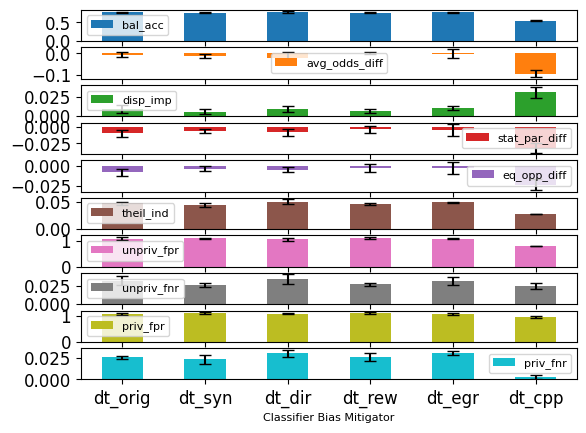

In [23]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

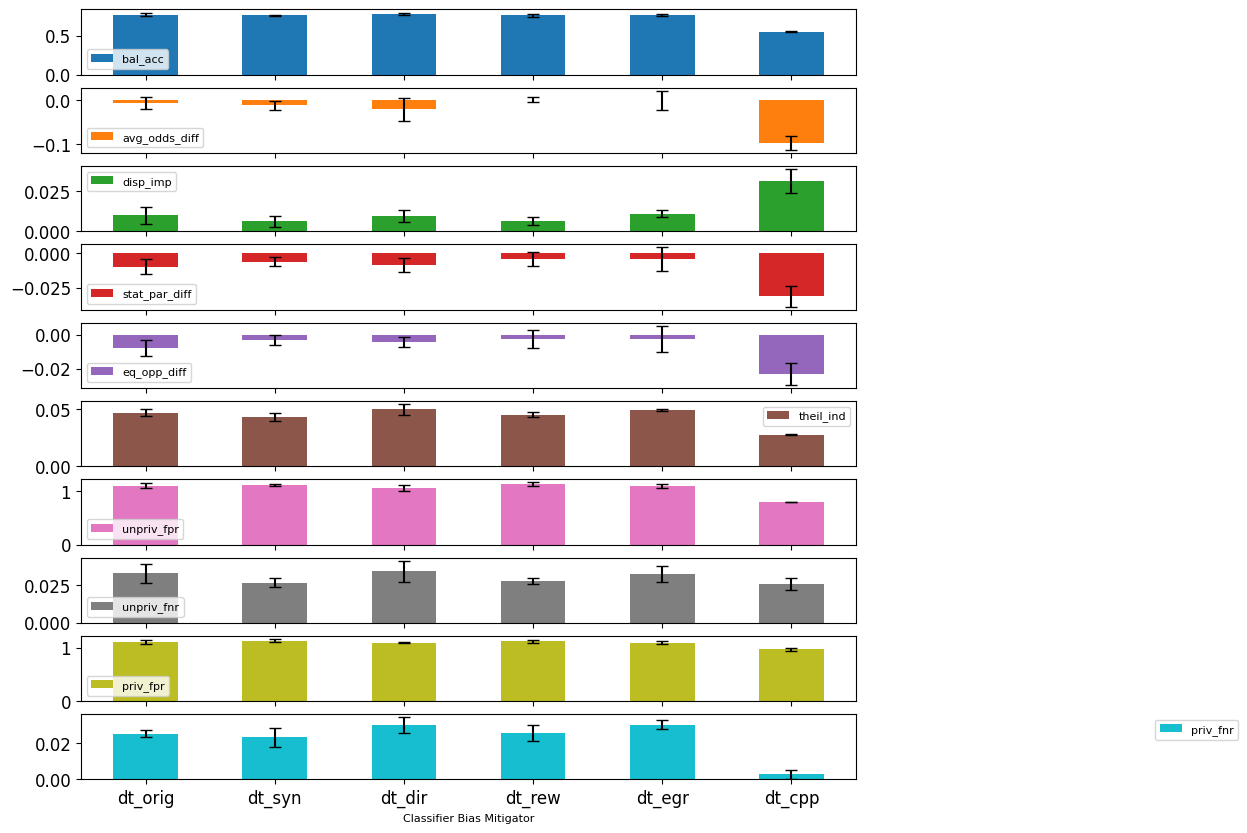

In [24]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [25]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.768070,-0.006299,0.009885,-0.009617,-0.007774,0.047081,1.099178,0.033089,1.104002,0.025315
dt_syn,0.758493,-0.011259,0.006165,-0.006039,-0.003342,0.043575,1.115153,0.026646,1.134329,0.023304
dt_dir,0.776713,-0.020522,0.009416,-0.008204,-0.004418,0.050042,1.062000,0.034532,1.098626,0.030114
dt_rew,0.756690,0.000981,0.006561,-0.003866,-0.002419,0.045453,1.128749,0.028012,1.124368,0.025592
dt_egr,0.768544,-0.000705,0.010882,-0.004336,-0.002459,0.049507,1.098535,0.032612,1.097487,0.030153
dt_cpp,0.548948,-0.096718,0.031283,-0.031174,-0.023039,0.027800,0.801613,0.025936,0.972010,0.002897


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [26]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [27]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.689505,0.908841,0.680907,0.913020,0.683278,0.923092,0.682280
syn,0.687326,0.878356,0.680706,0.894341,0.682648,0.864773,0.679774
dir,0.690996,0.908787,0.683475,0.921216,0.686188,0.905555,0.686237
rew,0.687807,0.885159,0.680578,0.882841,0.681431,0.895302,0.681572
egr,0.695964,0.913892,0.689638,0.913358,0.689809,0.926254,0.689573


In [28]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [29]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [30]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.913020,0.683278,0.923092,0.682280
syn,0.894341,0.682648,0.864773,0.679774
dir,0.921216,0.686188,0.905555,0.686237
rew,0.882841,0.681431,0.895302,0.681572
egr,0.913358,0.689809,0.926254,0.689573


<Axes: xlabel='Classifier MIA Attacks'>

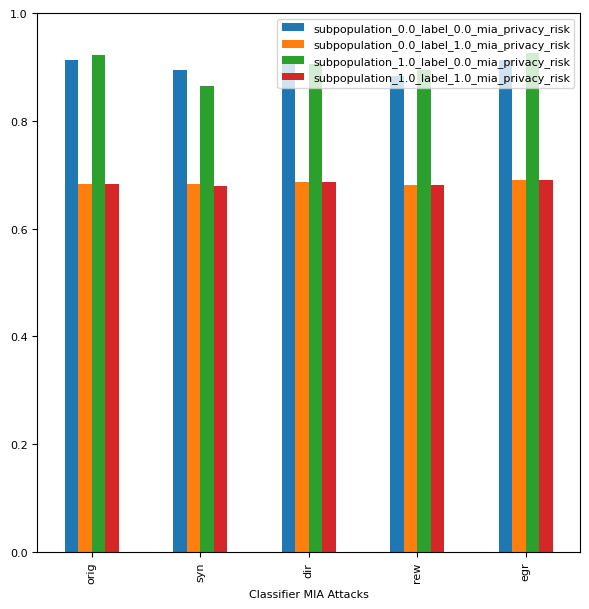

In [31]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [32]:
# Tabular Format
# importing the modules
from tabulate import tabulate

# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.91302   0.894341  0.921216  0.882841  0.913358
subpopulation_0.0_label_1.0_mia_privacy_risk  0.683278  0.682648  0.686188  0.681431  0.689809
subpopulation_1.0_label_0.0_mia_privacy_risk  0.923092  0.864773  0.905555  0.895302  0.926254
subpopulation_1.0_label_1.0_mia_privacy_risk  0.68228   0.679774  0.686237  0.681572  0.689573


### Visualizing using novel technique

In [33]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [34]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [35]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.516444
1,orig,entire_dataset_mia_privacy_risk,0.517838
2,orig,entire_dataset_mia_privacy_risk,0.517117
3,orig,entire_dataset_mia_privacy_risk,0.517117
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.647224
...,...,...,...
135,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.681965
136,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.514083
137,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.519143
138,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.517747


In [36]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.516444
1,orig,entire_dataset_mia_privacy_risk,0.517838
2,orig,entire_dataset_mia_privacy_risk,0.517117
3,orig,entire_dataset_mia_privacy_risk,0.517117
12,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.657696
...,...,...,...
135,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.681965
136,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.514083
137,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.519143
138,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.517747


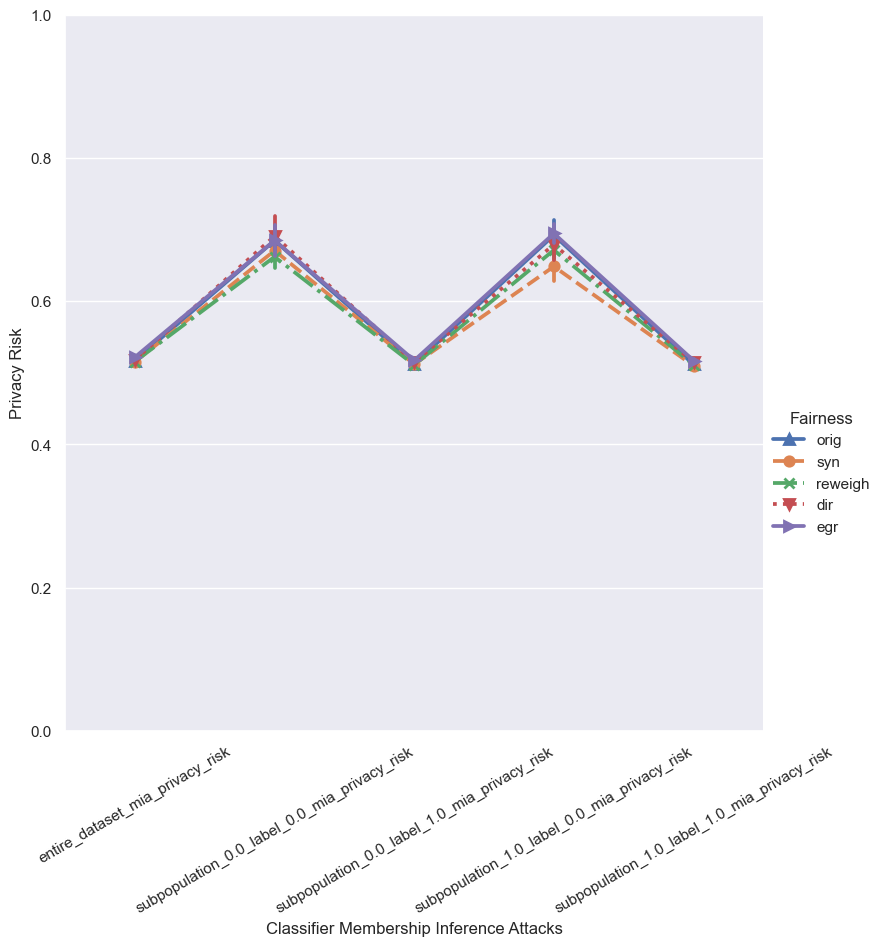

In [37]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [38]:
from sklearn.metrics import RocCurveDisplay, auc

In [39]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

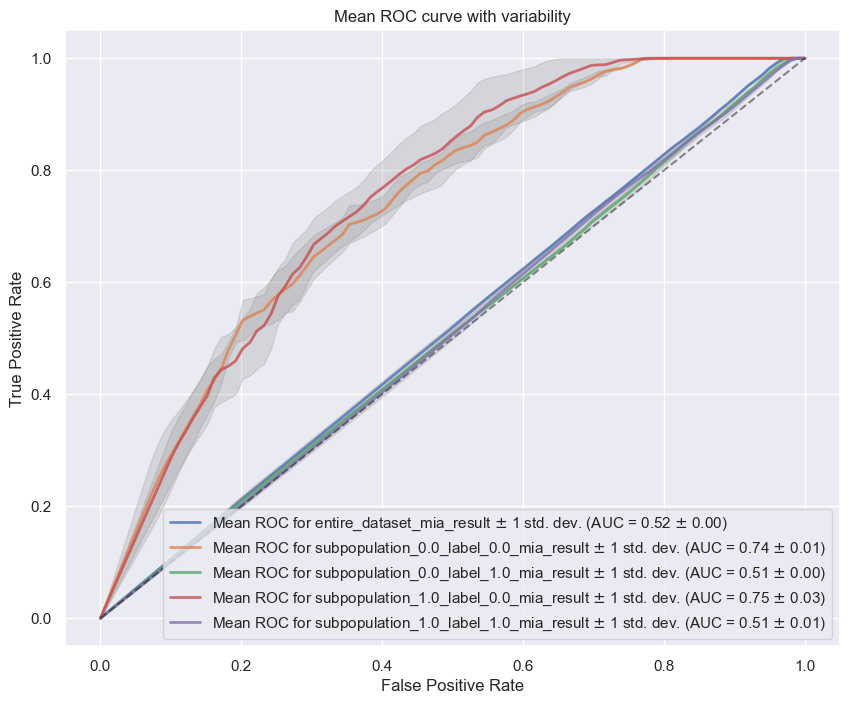

In [40]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

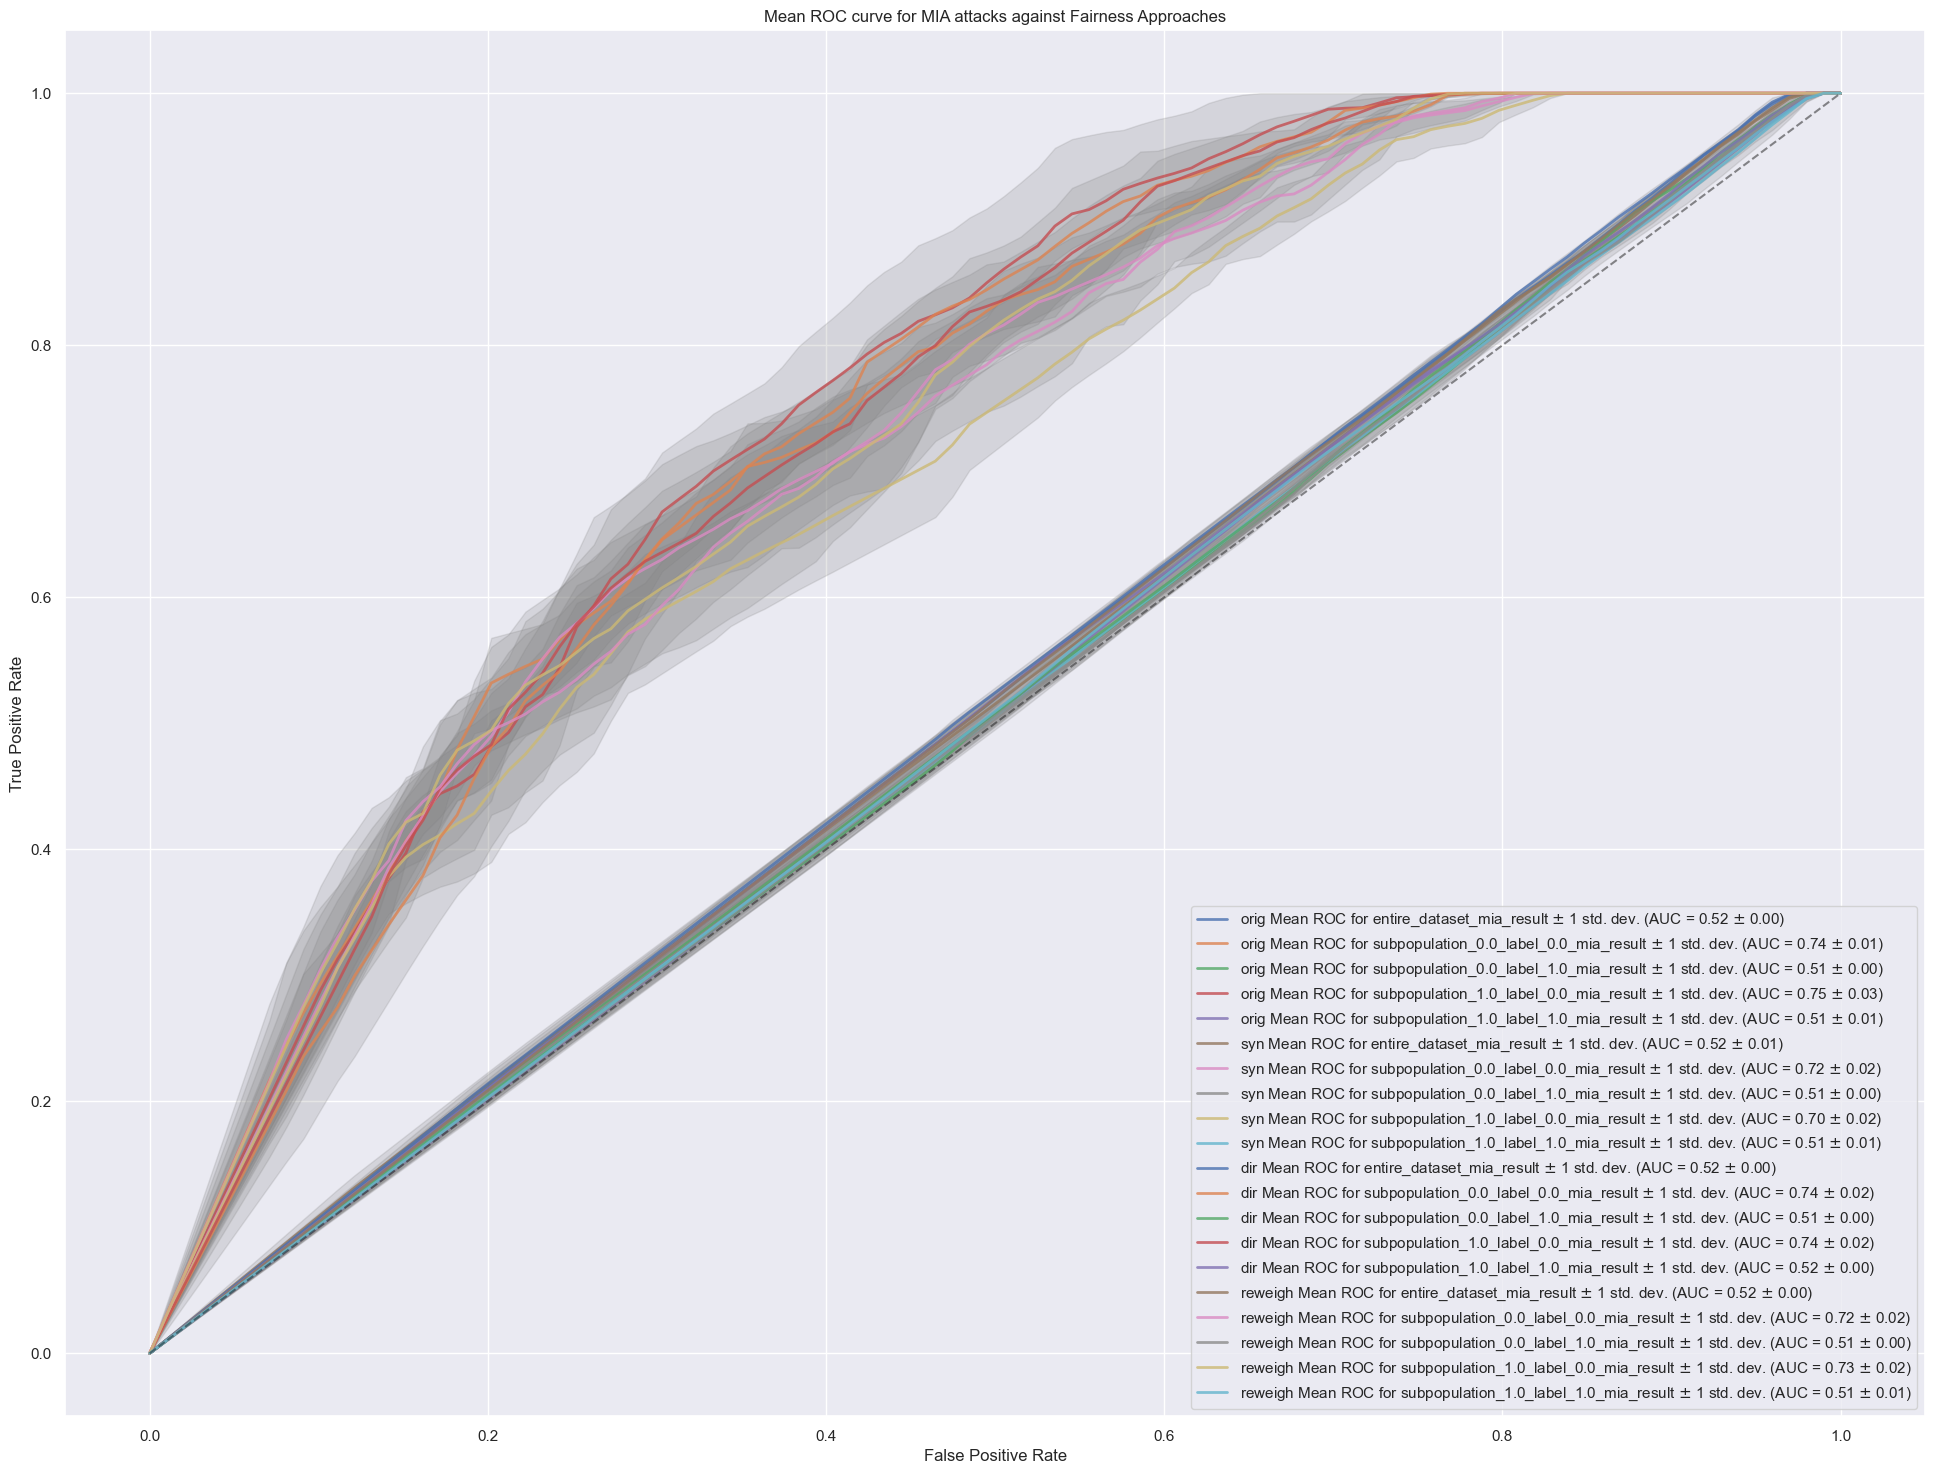

In [41]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

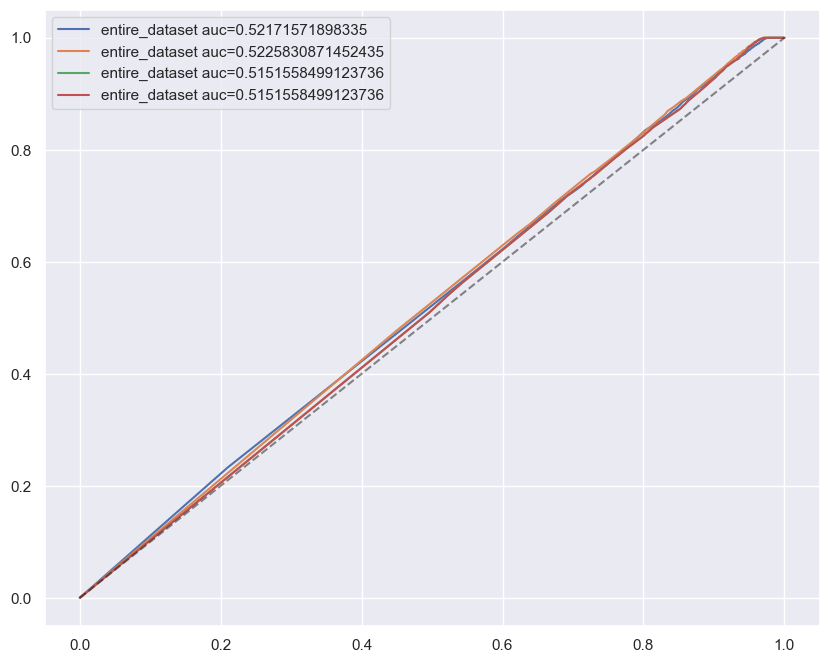

In [42]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [43]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [44]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.6915368353177803,
 'entire_dataset_label_0.0_mia_auc': 0.9915372857130084,
 'entire_dataset_label_1.0_mia_auc': 0.6792469351730178,
 'subpopulation_0.0_label_0.0_mia_auc': 0.9856677431657211,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6791959760459214,
 'subpopulation_1.0_label_0.0_mia_auc': 0.9982657734491814,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6789268195577791}

In [45]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.691537,0.991537,0.679247,0.985668,0.679196,0.998266,0.678927
syn,0.689195,0.950456,0.677138,0.966167,0.678177,0.934037,0.676293
dir,0.694588,0.984936,0.683803,0.984860,0.679092,0.983748,0.687555
rew,0.690134,0.968906,0.678342,0.965028,0.676154,0.972494,0.679819


<Axes: xlabel='Classifier MIA Attacks'>

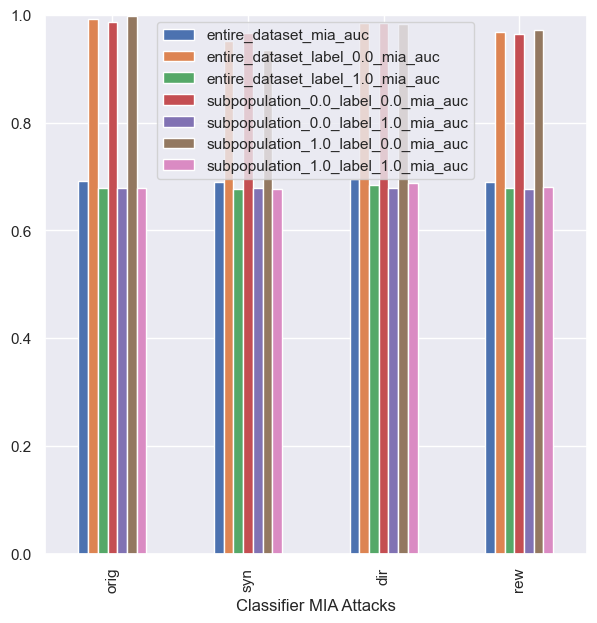

In [46]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [47]:
# Creating data structures to plot point categorical plot from seaborn

In [48]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [49]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.032887777670929874,
  0.03567650735647654,
  0.03423406096740067,
  0.03423406096740067],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.29444839015151514,
  0.40957606317402845,
  0.3745098039215686,
  0.3745098039215686],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.020486630112654725,
  0.023792339950164276,
  0.020581847912989337,
  0.020581847912989337],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.315392293267195,
  0.4105820105820106,
  0.3760722483991784,
  0.3760722483991784],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.0219260057769117,
  0.02735486963666267,
  0.025193606331381124,
  0.025193606331381124],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.2954875428305941,
  0.43280202072990165,
  0.4051316285954779,
  0.4051316285954779],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.0224953635047358,
  0.03659528815877633,
  0.017293788731878146,
  0.01729378873187

In [50]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.032887777670929874],
 ['orig', 'entire_dataset', 0.03567650735647654],
 ['orig', 'entire_dataset', 0.03423406096740067],
 ['orig', 'entire_dataset', 0.03423406096740067],
 ['orig', 'entire_dataset_label_0.0', 0.29444839015151514],
 ['orig', 'entire_dataset_label_0.0', 0.40957606317402845],
 ['orig', 'entire_dataset_label_0.0', 0.3745098039215686],
 ['orig', 'entire_dataset_label_0.0', 0.3745098039215686],
 ['orig', 'entire_dataset_label_1.0', 0.020486630112654725],
 ['orig', 'entire_dataset_label_1.0', 0.023792339950164276],
 ['orig', 'entire_dataset_label_1.0', 0.020581847912989337],
 ['orig', 'entire_dataset_label_1.0', 0.020581847912989337],
 ['orig', 'subpopulation_0.0_label_0.0', 0.315392293267195],
 ['orig', 'subpopulation_0.0_label_0.0', 0.4105820105820106],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3760722483991784],
 ['orig', 'subpopulation_0.0_label_0.0', 0.3760722483991784],
 ['orig', 'subpopulation_0.0_label_1.0', 0.0219260057769117],
 ['orig'

In [51]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.032888
1,orig,entire_dataset,0.035677
2,orig,entire_dataset,0.034234
3,orig,entire_dataset,0.034234
4,orig,entire_dataset_label_0.0,0.294448
...,...,...,...
135,egr,subpopulation_1.0_label_0.0,0.363931
136,egr,subpopulation_1.0_label_1.0,0.028165
137,egr,subpopulation_1.0_label_1.0,0.038285
138,egr,subpopulation_1.0_label_1.0,0.035494


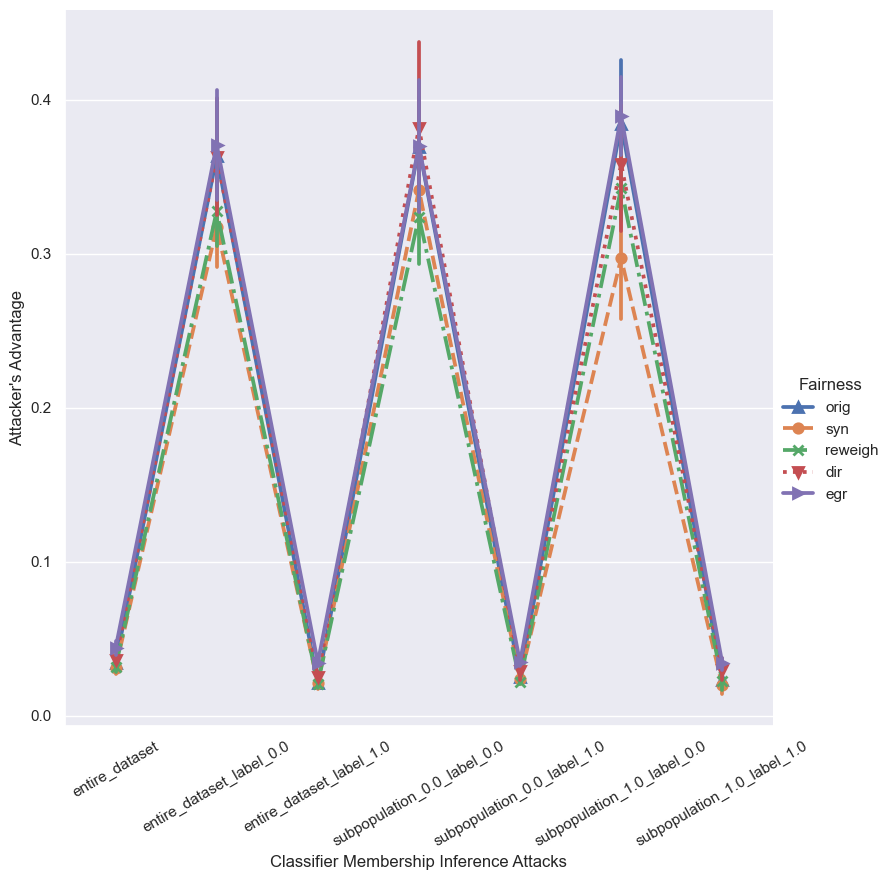

In [52]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


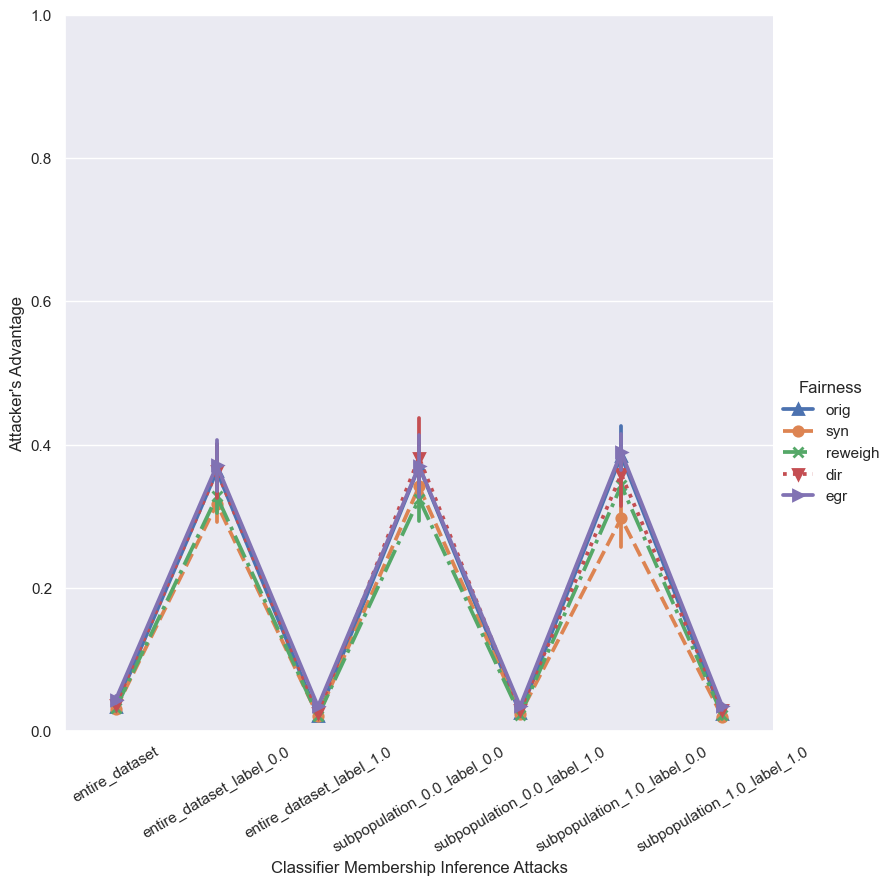

In [53]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [54]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.032888,0.294448,0.020487,0.315392,0.021926,0.295488,0.022495
1,0.035677,0.409576,0.023792,0.410582,0.027355,0.432802,0.036595
2,0.034234,0.374510,0.020582,0.376072,0.025194,0.405132,0.017294
3,0.034234,0.374510,0.020582,0.376072,0.025194,0.405132,0.017294


In [55]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("attacker_advantage")}

In [56]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.04567746898740258,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.48434802038956026,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.028480888629599226,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.4927062668825208,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.03322269602544554,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.5128509402504838,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.03122607637575614}

In [57]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.045677,0.484348,0.028481,0.492706,0.033223,0.512851,0.031226
syn,0.041318,0.423378,0.028079,0.455349,0.031963,0.396213,0.026215
dir,0.048659,0.484241,0.033617,0.509099,0.039043,0.477777,0.039140
rew,0.042280,0.436985,0.027822,0.432349,0.029528,0.457270,0.029810
egr,0.058595,0.494452,0.045943,0.493383,0.046284,0.519175,0.045813


<Axes: xlabel='Classifier MIA Attacks'>

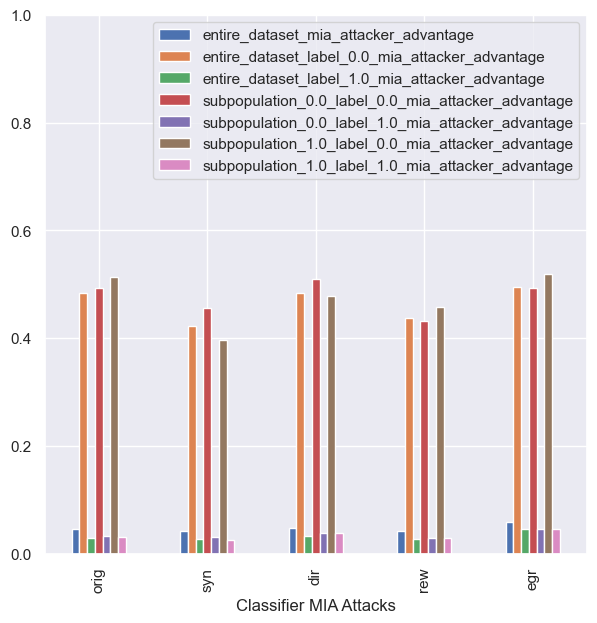

In [58]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [59]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("mia_ppv")}

In [60]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5257776810963672],
 ['orig', 'entire_dataset', 0.51477755885098],
 ['orig', 'entire_dataset', 0.5093053377871702],
 ['orig', 'entire_dataset', 0.5093053377871702],
 ['orig', 'entire_dataset_label_0.0', 0.7918552036199095],
 ['orig', 'entire_dataset_label_0.0', 0.771043771043771],
 ['orig', 'entire_dataset_label_0.0', 0.7255520504731862],
 ['orig', 'entire_dataset_label_0.0', 0.7255520504731862],
 ['orig', 'entire_dataset_label_1.0', 0.5132178669097539],
 ['orig', 'entire_dataset_label_1.0', 0.5068449197860962],
 ['orig', 'entire_dataset_label_1.0', 0.5052829139441124],
 ['orig', 'entire_dataset_label_1.0', 0.5052829139441124],
 ['orig', 'subpopulation_0.0_label_0.0', 0.801980198019802],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7707006369426751],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7388888888888889],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7388888888888889],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5294438386041439],
 ['orig', 'subpopulation_0

In [61]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.525778
1,orig,entire_dataset,0.514778
2,orig,entire_dataset,0.509305
3,orig,entire_dataset,0.509305
4,orig,entire_dataset_label_0.0,0.791855
...,...,...,...
135,egr,subpopulation_1.0_label_0.0,0.758929
136,egr,subpopulation_1.0_label_1.0,0.505036
137,egr,subpopulation_1.0_label_1.0,0.508835
138,egr,subpopulation_1.0_label_1.0,0.513788


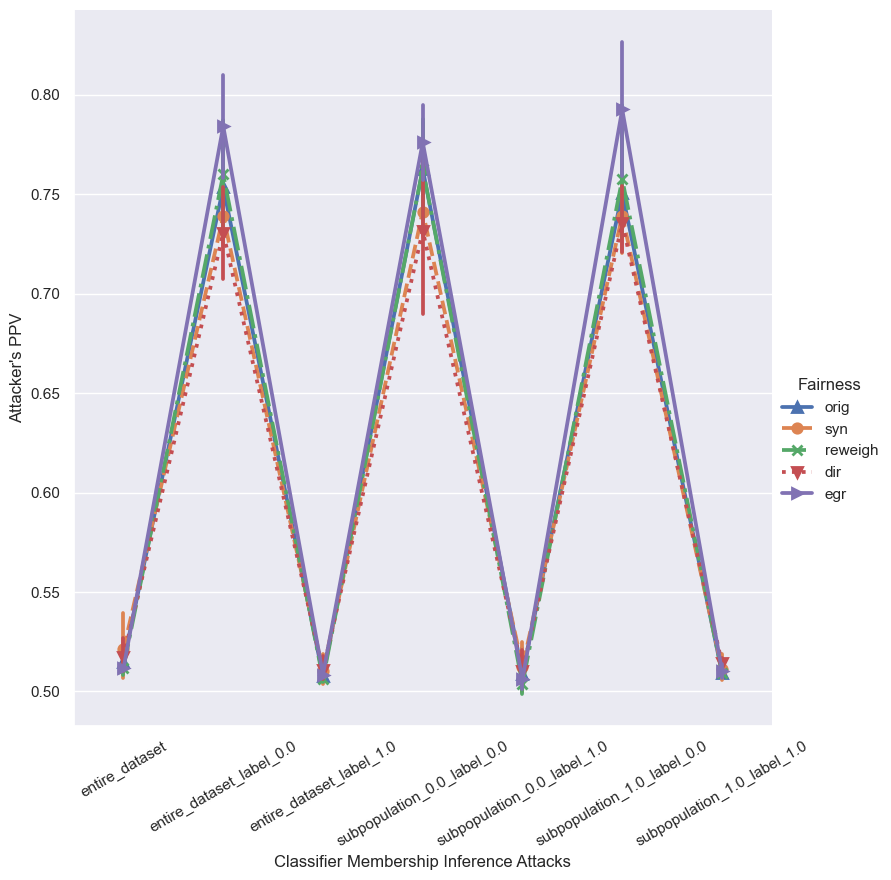

In [62]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [63]:
import pandas as pd

In [64]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,gender,race1,race2,other,asian,black,hisp,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,7.0,1.0,44.0,3.5,69.0,1.0,5.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,7.0,2.0,29.0,3.5,69.0,1.0,4.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,7.0,1.0,37.0,3.4,68.0,1.0,3.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,7.0,1.0
3,7.0,8.0,7.0,1.0,43.0,3.3,67.0,1.0,4.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,7.0,4.0,41.0,3.3,64.0,1.0,4.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,7.0,5.0,42.0,3.0,67.0,1.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,7.0,3.0,29.5,3.5,68.0,1.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,3.0,3.0,33.0,3.1,69.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,7.0,3.0,32.0,3.0,67.0,0.0,3.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,3.0,5.0,5.0,1.0


In [65]:
df[["age", "labels"]].value_counts(normalize=True)

KeyError: "['age'] not in index"

In [ ]:
df.drop_duplicates()